# Linear Regression Implementation from Scratch
:label:`sec_linear_scratch`

We're now ready to work through 
a fully functioning implementation 
of linear regression. 
In this section, 
(**we will implement the entire method from scratch,
including (i) the model; (ii) the loss function;
(iii) a minibatch stochastic gradient descent optimizer;
and (iv) the training function 
that stitches all of these pieces together.**)
Finally, we will run our synthetic data generator
from :numref:`sec_synthetic-regression-data`
and apply our model
on the resulting dataset. 
While modern deep learning frameworks 
can automate nearly all of this work,
implementing things from scratch is the only way
to make sure that you really know what you are doing.
Moreover, when it comes time to customize models,
defining our own layers or loss functions,
understanding how things work under the hood will prove handy.
In this section, we will rely only 
on tensors and automatic differentiation.
Later on, we will introduce a more concise implementation,
taking advantage of bells and whistles of deep learning frameworks 
while retaining the structure of what follows below.



\begin{exercise}
1) Use L1 instead L2 for loss function 
2) Modify this code to implement Ridge Regression and Lasso
\end{exercise}


# Elastic-Net

* Adds both L1 and L2 regularizations:

$$\mathcal{L}_{Elastic} = \sum_{n=1}^{N} (y_n-(\mathbf{w}\mathbf{x_n} + w_0))^2 + \alpha \rho \sum_{i=0}^{p} |w_i| + \alpha (1 -  \rho) \sum_{i=0}^{p} w_i^2$$ 

* $\rho$ is the L1 ratio
    * With $\rho=1$, $\mathcal{L}_{Elastic} = \mathcal{L}_{Lasso}$
    * With $\rho=0$, $\mathcal{L}_{Elastic} = \mathcal{L}_{Ridge}$
    * $0 < \rho < 1$ sets a trade-off between L1 and L2.
* Allows learning sparse models (like Lasso) while maintaining L2 regularization benefits
    * E.g. if 2 features are correlated, Lasso likely picks one randomly, Elastic-Net keeps both 
* Weights can be optimized using coordinate descent (similar to Lasso) 

\begin{exercise}
Implement the Elastic-Net and test it for different values of hyper-parameters.

\end{exercise}


In [1]:
%matplotlib inline
from mxnet import autograd, np, npx
from d2l import mxnet as d2l

npx.set_np()

## Defining the Model

[**Before we can begin optimizing our model's parameters**] by minibatch SGD,
(**we need to have some parameters in the first place.**)
In the following we initialize weights by drawing
random numbers from a normal distribution with mean 0
and a standard deviation of 0.01. 
The magic number 0.01 often works well in practice, 
but you can specify a different value 
through the argument `sigma`.
Moreover we set the bias to 0.
Note that for object-oriented design
we add the code to the `__init__` method of a subclass of `d2l.Module` (introduced in :numref:`subsec_oo-design-models`).


In [2]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, alpha, rho, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = np.random.normal(0, sigma, (num_inputs, 1))
        self.b = np.zeros(1)
        self.w.attach_grad()
        self.b.attach_grad()

Next, we must [**define our model,
relating its input and parameters to its output.**]
Using the same notation in :eqref:`eq_linreg-y-vec`,
for our linear model we simply take the matrix-vector product
of the input features $\mathbf{X}$ 
and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.
$\mathbf{Xw}$ is a vector and $b$ is a scalar.
Due to the broadcasting mechanism 
(see :numref:`subsec_broadcasting`),
when we add a vector and a scalar,
the scalar is added to each component of the vector.
The resulting `forward` method 
is registered in the `LinearRegressionScratch` class
via `add_to_class` (introduced in :numref:`oo-design-utilities`).


In [3]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return np.dot(X, self.w) + self.b

## Defining the Loss Function

Since [**updating our model requires taking
the gradient of our loss function,**]
we ought to (**define the loss function first.**)
Here we use the squared loss function
in :eqref:`eq_mse`.
In the implementation, we need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following method
will also have the same shape as `y_hat`. 
We also return the averaged loss value
among all examples in the minibatch.


In [4]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):    
    # This is the L1 loss
    # l_1 = np.abs(y_hat - y)

    # This is the L2 loss
    # l_2 = (y_hat - y) ** 2 / 2

    # The Ridge regression loss
    # l = self.alpha * np.square(self.w).sum() + l_2

    # The Lasso regression loss
    # l= self.alpha * np.abs(self.w).sum() + l_1

    # The Elastic Net loss
    l1_loss = self.alpha *self.rho * np.abs(self.w).sum()
    l2_loss = self.alpha * (1 - self.rho) * np.square(self.w).sum() /2
    l = l1_loss + l2_loss 

    return l.mean()

## Defining the Optimization Algorithm

As discussed in :numref:`sec_linear_regression`,
linear regression has a closed-form solution.
However, our goal here is to illustrate 
how to train more general neural networks,
and that requires that we teach you 
how to use minibatch SGD.
Hence we will take this opportunity
to introduce your first working example of SGD.
At each step, using a minibatch 
randomly drawn from our dataset,
we estimate the gradient of the loss
with respect to the parameters.
Next, we update the parameters
in the direction that may reduce the loss.

The following code applies the update, 
given a set of parameters, a learning rate `lr`.
Since our loss is computed as an average over the minibatch, 
we do not need to adjust the learning rate against the batch size. 
In later chapters we will investigate 
how learning rates should be adjusted
for very large minibatches as they arise 
in distributed large scale learning.
For now, we can ignore this dependency.


We define our `SGD` class, 
a subclass of `d2l.HyperParameters` (introduced in :numref:`oo-design-utilities`),
to have a similar API
as the built-in SGD optimizer.
We update the parameters in the `step` method.
It accepts a `batch_size` argument that can be ignored.


In [5]:
class SGD(d2l.HyperParameters):  #@save
    # """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self, _):
        for param in self.params:
            param -= self.lr * param.grad

We next define the `configure_optimizers` method, which returns an instance of the `SGD` class.


In [6]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

## Training

Now that we have all of the parts in place
(parameters, loss function, model, and optimizer),
we are ready to [**implement the main training loop.**]
It is crucial that you understand this code well
since you will employ similar training loops
for every other deep learning model
covered in this book.
In each *epoch*, we iterate through 
the entire training dataset, 
passing once through every example
(assuming that the number of examples 
is divisible by the batch size). 
In each iteration, we grab a minibatch of training examples,
and compute its loss through the model's `training_step` method. 
Next, we compute the gradients with respect to each parameter. 
Finally, we will call the optimization algorithm
to update the model parameters. 
In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$
 
Recall that the synthetic regression dataset 
that we generated in :numref:``sec_synthetic-regression-data`` 
does not provide a validation dataset. 
In most cases, however, 
we will use a validation dataset 
to measure our model quality. 
Here we pass the validation dataloader 
once in each epoch to measure the model performance.
Following our object-oriented design,
the `prepare_batch` and `fit_epoch` methods
are registered in the `d2l.Trainer` class
(introduced in :numref:`oo-design-training`).


In [7]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

In [8]:
@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    for batch in self.train_dataloader:
        with autograd.record():
            loss = self.model.training_step(self.prepare_batch(batch))
        loss.backward()
        if self.gradient_clip_val > 0:
            self.clip_gradients(self.gradient_clip_val, self.model)
        self.optim.step(1)
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    for batch in self.val_dataloader:
        self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

We are almost ready to train the model,
but first we need some data to train on.
Here we use the `SyntheticRegressionData` class 
and pass in some ground-truth parameters.
Then, we train our model with 
the learning rate `lr=0.03` 
and set `max_epochs=3`. 
Note that in general, both the number of epochs 
and the learning rate are hyperparameters.
In general, setting hyperparameters is tricky
and we will usually want to use a 3-way split,
one set for training, 
a second for hyperparameter seclection,
and the third reserved for the final evaluation.
We elide these details for now but will revise them
later.


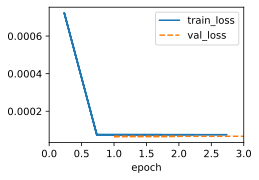

In [9]:

# model = LinearRegressionScratch(2, lr=0.03)
# model = LinearRegressionScratch(2, lr=0.03, alpha=0.1)
model = LinearRegressionScratch(2, lr=0.03, alpha=0.1, rho=0.5)
data = d2l.SyntheticRegressionData(w=np.array([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Because we synthesized the dataset ourselves,
we know precisely what the true parameters are.
Thus, we can [**evaluate our success in training
by comparing the true parameters
with those that we learned**] through our training loop.
Indeed they turn out to be very close to each other.


In [10]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: [ 2.000483  -3.4008522]
error in estimating b: [4.2]
